In [ ]:
# Klinkenberg Effect: Estimating Absolute Permeability using Linear Regression

#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [ ]:
# Enter Lab Data

# Mean pressure values in psi
p_m = np.array([300, 500, 700, 900, 1100])

# Corresponding gas permeability measurements in mD
k_g = np.array([0.53, 0.50, 0.48, 0.47, 0.46])

# Calculate inverse pressure values
inv_pm = 1 / p_m


In [ ]:
# Fit Linear Regression Model (k_g = k_L + b/p_m)

# Reshape arrays for sklearn
X = inv_pm.reshape(-1, 1)  # Independent variable (1/p_m)
y = k_g.reshape(-1, 1)     # Dependent variable (k_g)

# Create and train the model
model = LinearRegression()
model.fit(X, y)

# Extract slope and intercept
b = model.coef_[0][0]
k_L = model.intercept_[0]

# Print results
print(f"Estimated Absolute Permeability (k_L): {k_L:.4f} mD")
print(f"Klinkenberg Slip Factor (b): {b:.4f} mD·psi")


Estimated Absolute Permeability (k_L): 0.4383 mD
Klinkenberg Slip Factor (b): 28.2790 mD·psi


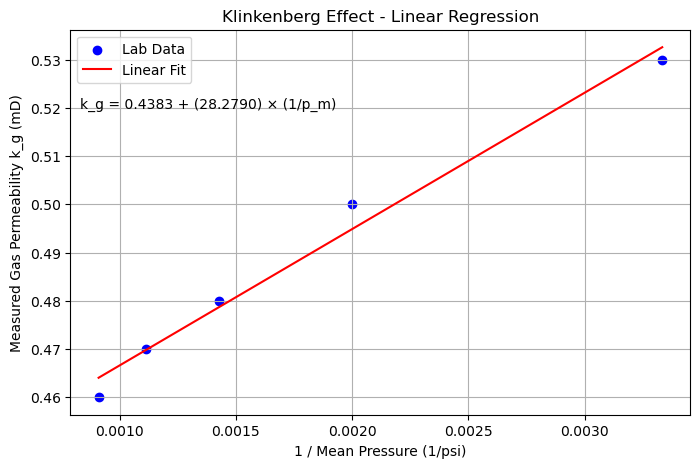

In [ ]:
# Plotting

# Generate fitted line values
x_fit = np.linspace(min(inv_pm), max(inv_pm), 100).reshape(-1, 1)
y_fit = model.predict(x_fit)

# Create plot
plt.figure(figsize=(8,5))
plt.scatter(inv_pm, k_g, color='blue', label='Lab Data')
plt.plot(x_fit, y_fit, color='red', label='Linear Fit')

plt.xlabel('1 / Mean Pressure (1/psi)')
plt.ylabel('Measured Gas Permeability k_g (mD)')
plt.title('Klinkenberg Effect - Linear Regression')
plt.legend()
plt.grid(True)

# Add equation text to plot
equation = f"k_g = {k_L:.4f} + ({b:.4f}) × (1/p_m)"
plt.text(x=0.00083, y=max(k_g) - 0.01, s=equation, fontsize=10, color='black')

plt.show()


In [ ]:
# Summary

print("===== SUMMARY =====")
print(f"Gas Permeability Data (k_g): {k_g}")
print(f"Mean Pressures (p_m): {p_m}")
print(f"Inverse Pressures (1/p_m): {inv_pm}")
print()
print(f"Estimated Absolute Permeability (k_L): {k_L:.4f} mD")
print(f"Estimated Slip Factor (b): {b:.4f} mD·psi")
print()
print("Model Equation:")
print(f"    k_g = {k_L:.4f} + ({b:.4f}) / p_m")


===== SUMMARY =====
Gas Permeability Data (k_g): [0.53 0.5  0.48 0.47 0.46]
Mean Pressures (p_m): [ 300  500  700  900 1100]
Inverse Pressures (1/p_m): [0.00333333 0.002      0.00142857 0.00111111 0.00090909]

Estimated Absolute Permeability (k_L): 0.4383 mD
Estimated Slip Factor (b): 28.2790 mD·psi

Model Equation:
    k_g = 0.4383 + (28.2790) / p_m


In [12]:
# --- Newton-Raphson Functions ---

def f_nr(k_L, p_m_i, k_g_i):
    return 6.9 * (k_L ** 0.64) + p_m_i * k_L - p_m_i * k_g_i

def f_prime_nr(k_L, p_m_i):
    return 4.416 * (k_L ** -0.36) + p_m_i

def newton_r(k_g_i, p_m_i, guess=0.5, tol=1e-6, max_iter=100):
    k = guess
    for _ in range(max_iter):
        f_val = f_nr(k, p_m_i, k_g_i)
        f_der = f_prime_nr(k, p_m_i)
        if f_der == 0:
            break
        k_new = k - f_val / f_der
        if abs(k_new - k) < tol:
            return k_new
        k = k_new
    return None  # did not converge


In [13]:
# --- Applying Newton-Raphson to All Data Points ---

kL_nr_list = []
b_nr_list = []
kg_pred_nr_list = []

for i in range(len(p_m)):
    k_L_nr = newton_r(k_g[i], p_m[i])
    if k_L_nr:
        b_nr = 6.9 * k_L_nr**(-0.36)
        kg_pred = k_L_nr + b_nr / p_m[i]
    else:
        k_L_nr, b_nr, kg_pred = None, None, None
    kL_nr_list.append(k_L_nr)
    b_nr_list.append(b_nr)
    kg_pred_nr_list.append(kg_pred)


In [14]:
# --- Get Linear Regression Predictions ---

kg_pred_reg = model.predict(inv_pm.reshape(-1,1)).flatten()


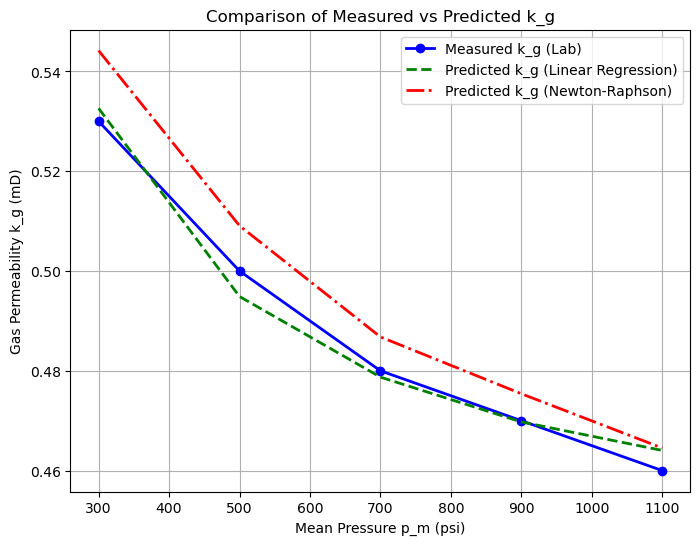

In [15]:
# --- Plot Comparison ---

plt.figure(figsize=(8,6))
plt.plot(p_m, k_g, 'bo-', label='Measured k_g (Lab)', linewidth=2)
plt.plot(p_m, kg_pred_reg, 'g--', label='Predicted k_g (Linear Regression)', linewidth=2)
plt.plot(p_m, kg_pred_nr_list, 'r-.', label='Predicted k_g (Newton-Raphson)', linewidth=2)

plt.xlabel('Mean Pressure p_m (psi)')
plt.ylabel('Gas Permeability k_g (mD)')
plt.title('Comparison of Measured vs Predicted k_g')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# --- Summary Table ---

df_results = pd.DataFrame({
    'p_m (psi)': p_m,
    'Measured k_g (mD)': k_g,
    'k_L (NR)': kL_nr_list,
    'b (NR)': b_nr_list,
    'k_g (NR Predicted)': kg_pred_nr_list,
    'k_g (Regression Predicted)': kg_pred_reg
})

print("\nSummary Table (rounded to 4 decimals):")
print(df_results.round(4))



Summary Table (rounded to 4 decimals):
   p_m (psi)  Measured k_g (mD)  k_L (NR)  b (NR)  k_g (NR Predicted)  \
0        300               0.53    0.5150  8.7622              0.5442   
1        500               0.50    0.4912  8.9121              0.5091   
2        700               0.48    0.4739  9.0283              0.4868   
3        900               0.47    0.4653  9.0879              0.4754   
4       1100               0.46    0.4562  9.1528              0.4645   

   k_g (Regression Predicted)  
0                      0.5326  
1                      0.4949  
2                      0.4787  
3                      0.4698  
4                      0.4640  
